<a href="https://colab.research.google.com/github/K-YUTAA/kit-extension-sample-airoomgenerator/blob/main/Report/IMISToolA2025_Report4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Report 4 (2025/07/28 ver.A)

for Tools for intelligent interaction systems a (0ALE005 / 0AL5707).

---

<font color="red">
If Ver.B or later, change log should be found at the end of this page.  

Your ID info should be placed in the following three items (MANDATORY).
</font>

* Student ID: (E.g. 202099998)...Erase-and-put-yours-here
* Name: (E.g. 筑波 太郎）...Erase-and-put-yours-here
* Colab account: (E.g. tsukuba.taro.xs@alumni.tsukuba.ac.jp)...Erase-and-put-yours-here

---

Report could be written in English or Japanese. / レポートの記述は日本語でも英語でもよい．

---

---
# Report4A: Live capture query with CIFAR-10 or MNIST  

* Show the way to build a classfier of CIFAR10 or MNIST.
* Provide a python program that captures an image from a camera and that shows its recognition result of the image immediately.

Hint: Each shown in tutorials. Find a way to unite them.



In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
print ('You can put code cells and text cells around here.')

You can put code cells and text cells around here.


In [ ]:
import os
import math
import time
import io
import base64
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

# For Colab camera and JS interop
from IPython.display import display, Javascript, HTML
from google.colab import output, files

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:

# Normalization values for MNIST
MNIST_MEAN, MNIST_STD = 0.1307, 0.3081

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
])

data_root = "./data"
train_ds = datasets.MNIST(root=data_root, train=True, download=True, transform=transform_train)
test_ds  = datasets.MNIST(root=data_root, train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]


(60000, 10000)

In [ ]:

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 14x14 -> 14x14 (after pool)
        self.pool = nn.MaxPool2d(2,2)                # halves size
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SmallCNN().to(device)
print(model)


SmallCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

def train(model, train_loader, test_loader, device, epochs=2, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for i, (x, y) in enumerate(train_loader, 1):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            opt.step()
            running_loss += loss.item()
            if i % 100 == 0:
                print(f"Epoch {epoch} | step {i}/{len(train_loader)} | loss {running_loss/100:.4f}")
                running_loss = 0.0
        acc = evaluate(model, test_loader, device)
        print(f"[Epoch {epoch}] Test accuracy: {acc*100:.2f}%")
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "mnist_cnn.pt")
            print("Saved checkpoint: mnist_cnn.pt (best so far)")
    print(f"Best accuracy: {best_acc*100:.2f}%")


In [ ]:

# If a checkpoint exists, load it. Otherwise, train quickly (2 epochs).
ckpt_path = Path("mnist_cnn.pt")
if ckpt_path.exists():
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    print("Loaded existing checkpoint:", ckpt_path)
else:
    print("No checkpoint found. Start training...")
    train(model, train_loader, test_loader, device, epochs=2, lr=1e-3)
    print("Training done.")

print("Final test accuracy:", evaluate(model, test_loader, device)*100, "%")


No checkpoint found. Start training...
Epoch 1 | step 100/469 | loss 0.5648
Epoch 1 | step 200/469 | loss 0.1542
Epoch 1 | step 300/469 | loss 0.1187
Epoch 1 | step 400/469 | loss 0.0919
[Epoch 1] Test accuracy: 98.32%
Saved checkpoint: mnist_cnn.pt (best so far)
Epoch 2 | step 100/469 | loss 0.0696
Epoch 2 | step 200/469 | loss 0.0697
Epoch 2 | step 300/469 | loss 0.0671
Epoch 2 | step 400/469 | loss 0.0601
[Epoch 2] Test accuracy: 98.73%
Saved checkpoint: mnist_cnn.pt (best so far)
Best accuracy: 98.73%
Training done.
Final test accuracy: 98.72999999999999 %


In [ ]:

import cv2

def preprocess_to_mnist(path, debug=False):
    # Preprocess an arbitrary image (color or gray) into MNIST-like tensor.
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Heuristic inversion to match MNIST (white digit on dark background)
    if gray.mean() > 128:
        gray = 255 - gray

    # Threshold to get bounding box
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ys, xs = np.where(th > 0)
    if len(xs) > 0 and len(ys) > 0:
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()
        roi = gray[y1:y2+1, x1:x2+1]
    else:
        roi = gray

    # Resize longer side to 20, keep aspect, then pad to 28x28
    h2, w2 = roi.shape[:2]
    scale = 20.0 / max(h2, w2) if max(h2, w2) > 0 else 1.0
    new_size = (max(1, int(round(w2*scale))), max(1, int(round(h2*scale))))
    roi_resized = cv2.resize(roi, new_size, interpolation=cv2.INTER_AREA)

    canvas = np.zeros((28, 28), dtype=np.uint8)
    y_off = (28 - roi_resized.shape[0]) // 2
    x_off = (28 - roi_resized.shape[1]) // 2
    canvas[y_off:y_off+roi_resized.shape[0], x_off:x_off+roi_resized.shape[1]] = roi_resized

    tensor = torch.from_numpy(canvas).float().unsqueeze(0).unsqueeze(0) / 255.0
    tensor = (tensor - MNIST_MEAN) / MNIST_STD
    if debug:
        plt.figure()
        plt.title("Preprocessed 28x28")
        plt.imshow(canvas, cmap='gray')
        plt.axis('off')
        plt.show()
    return tensor.to(device), canvas


<IPython.core.display.Javascript object>

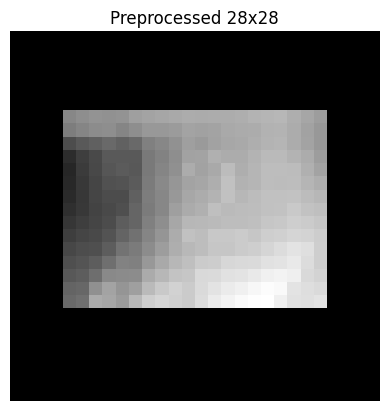

Prediction: 2  (confidence: 46.75%)


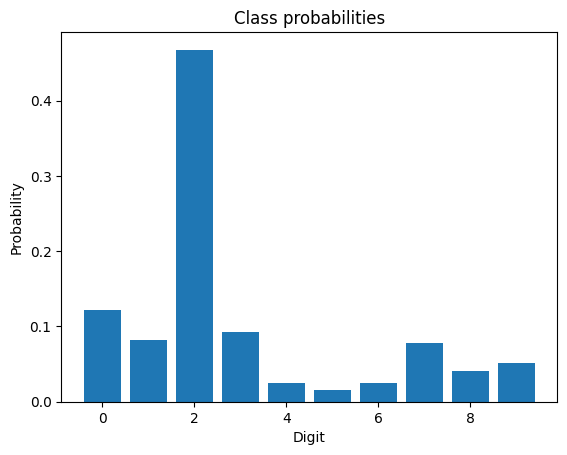

In [ ]:

# Colab webcam capture + prediction
def take_photo(filename='capture.jpg', quality=0.9):
    # Opens the webcam in the browser and captures one frame into `filename`.
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const video = document.createElement('video');
        const btn = document.createElement('button');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        div.appendChild(btn);
        video.style.maxWidth = '480px';
        btn.textContent = '📸 Capture';
        video.srcObject = stream;
        await video.play();
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => { btn.onclick = resolve; });
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = output.eval_js('takePhoto({})'.format(quality))
    if not data:
        print("No photo captured.")
        return None
    binary = base64.b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def predict_image_tensor(x):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        pred = int(np.argmax(probs))
        conf = float(np.max(probs))
    return pred, conf, probs

save_path = take_photo('capture.jpg', quality=0.9)
if save_path is not None:
    # 元のキャプチャ画像を表示
    img_bgr = cv2.imread(save_path)               # BGR形式で読み込み
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # RGBに変換
    plt.figure()
    plt.title("Captured Image")
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    # 前処理と予測
    x, canvas = preprocess_to_mnist(save_path, debug=True)
    pred, conf, probs = predict_image_tensor(x)
    print(f"Prediction: {pred}  (confidence: {conf*100:.2f}%)")

    # クラス確率のバー表示
    plt.figure()
    plt.title("Class probabilities")
    plt.bar(range(10), probs)
    plt.xlabel("Digit")
    plt.ylabel("Probability")
    plt.show()


(You can put text cells around here)

---
# Report4B: Tutorials of pytorch

There are [many tutorials](https://github.com/kameda-yoshinari/IMISToolExeA2021/blob/master/300_PyTorch.ipynb) provided by the Pytorch official site. Pick up **four tutorials** (you should complete those tutorials) and make a report for the four tutorials on:

* Summary (2-3 lines)
* What you learn
* The most difficult part

Note that you can choose the first two (mandatory ones) in the four choices.
However, you should not take all fours in basic category (at least one should be from other category).

---
# Report4C: Unique features of PyTorch found in Tutorials

Throughout the tutorial experience of Report4B, what do you find as the unique features of PyTorch (compared with other ML libraries)?
As for the generic PyTorch features, you should find appopriate part in the tutorials / documents in the official pytorch www, site them, and poiencounteredurce and the features.   
Then summersize them totally from your viewpoint.

* List up at least two unique features. (+ URL, sentences to fit, and short description for each)
* Point the encountered unique features in your tutorial experience in Report4B and write how you feel it actually. (You can pick up one of the four tutorial experiences.)


(You can put text cells around here)

---
# Report4D: AI support to learn python and PyTorch  

Find out the state-of-the-art AI support which is available / helpful on learning how to write python / pytorch codes on google colab.
Then write your own comment on what kind of changes would happen on PyTorch in a couple of years.

* AI service name
* AI service "official web site"
* Major funcitons of provided support
* The service start date and version history (including the URL that holds such info)


(You can put text cells around here)

---
#Report4E: Your Goole drive usage

Find out the amount of your google drive space and report it.  
Discuss the availability and what you should do to make it small.


(You can put text cells around here)

---
# Report submission

The report template will be given in ipynb file.  

You should save this file as a report templete to your local google colaboratory folder and then edit it to fit your report.

The report submission should be made at this cource (0ALE005) at https://manaba.tsukuba.ac.jp .  
Note that 0AL5707 is coupled with 0ALE005 on manaba system, so 0AL5707 students should also submit the report at 0ALE005.  
File extension should be **ipynb**. Other format won't be accepted.  







---
Tools and Practices for Intelligent Interaction Systems A  
Master's and Docotal programs in intelligent and mechanical interaction systems, University of Tsukuba, Japan.  
KAMEDA Yoshinari, SHIBUYA Takeshi  

知能システムツール演習a  
知能機能システム学位プログラム (筑波大学大学院)  
担当：亀田能成，澁谷長史  

2025/07/28. Ver.A.  


